# Mall Customer Segmentation

## Introduction 

This dataset has been found on kaggle. [1]

You are owing a supermarket mall and through membership cards , you have some basic data about your customers like :

- Customer ID
- age
- gender
- annual income 
- spending score.

Spending Score is something you assign to the customer based on your defined parameters like customer behavior and purchasing data.

Problem Statement : 
You own the mall and want to understand the customers like who can be easily converge [Target Customers] so that the sense can be given to marketing team and plan the strategy accordingly.

We'll so developp different unsupervised model of machine learning :

- K-Means
- Aggomerative Clustering
- DBSCAN
- Affinity Propagation

### Import the libraries and DataSet

In [18]:

#import libraries to manipulate and visualize data

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly as py
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly_express as px
import seaborn as sns
from cProfile import label
from math import pi
from sklearnex import patch_sklearn


#import machine learning model
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import AffinityPropagation
from yellowbrick.cluster import KElbowVisualizer



from sklearn.metrics import silhouette_score

from sklearn.metrics import silhouette_samples
from itertools import product
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 

#import parallel processing libraries
from multiprocessing import cpu_count
from multiprocessing.pool import ThreadPool
import multiprocessing as mp

#import libraries to save model
import joblib




In [2]:
#Make the machine learning runnin quicker
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
# Fix the number of CPU used :
nCPU = os.cpu_count()
pool = ThreadPool(processes=nCPU)

In [5]:
#import the data
path = os.path.abspath("../Data/Mall_Customers.csv")

# import the data into a pandas dataframe :
# Import DataSet with parallelization on the different Cpus
def import_df(file_name):
    df = pd.read_csv(file_name)
    return df
df = pool.apply_async(import_df, (path, )).get()

### Data Presentation

In [6]:
#show the data
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [7]:
#Display the size of the DataSet
print(f"The dataframe contains {df.shape[0]} rows and {df.shape[1]} columns")

The dataframe contains 200 rows and 5 columns


In [8]:
df.dtypes

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

In [9]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [10]:
#count the number of null values
print(f"There are {df.isna().sum().sum()} missing values in the dataset.")

There are 0 missing values in the dataset.


### Exploratory data analysis

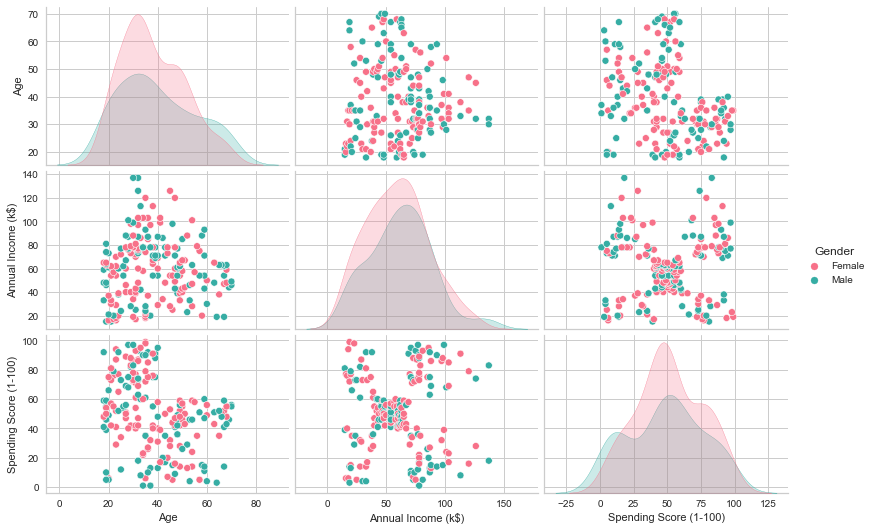

In [11]:
#inverse the color of the palette of seaborn

sns.pairplot(df.drop('CustomerID', axis=1), hue='Gender', palette= 'husl', hue_order = ['Female', 'Male'], aspect=1.5)

In [6]:
plot_df=df.copy()
plot_df['Annual Income (k$)']=plot_df['Annual Income (k$)'].mul(1000)
p1=plot_df.groupby('Gender')['Age'].mean().round(0).astype(int).reset_index()
p2=plot_df.groupby('Gender')['Annual Income (k$)'].mean().reset_index()
p3=plot_df.groupby('Gender')['Spending Score (1-100)'].mean().round(0).astype(int).reset_index()

#adjust the size of the plot

temp = dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12)))
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=("Distribution of Age<br>by Gender", 
                                    "Customers Average Age",
                                    )
                   )

fig.add_trace(go.Histogram(x=plot_df[plot_df.Gender=='Male']['Age'], histnorm='probability density', 
                           marker=dict(color='#508B8D',opacity=0.7, line=dict(width=1, color='#000000')), 
                           nbinsx=20, name="Men"),
              row=1, col=1)
fig.add_trace(go.Histogram(x=plot_df[plot_df.Gender=='Female']['Age'], histnorm='probability density', 
                           marker=dict(color='#F3D6CB',opacity=0.7, line=dict(width=1, color='#000000')),
                           nbinsx=20, name="Women"),
              row=1, col=1)

fig.add_trace(go.Bar(x=p1['Gender'], y=p1['Age'], text=p1['Age'], texttemplate='%{text} years', textposition='inside',
                     marker=dict(color=['#F0CABD', '#508B8D'], opacity=0.8),width=.8,
                     hovertemplate='Average Age Among %{x} = %{y} years<extra></extra>', showlegend=False),
              row=1, col=2)

fig.update_layout(template=temp,barmode='overlay', height=500, width=700,
                  legend=dict(orientation="h", yanchor="bottom", xanchor="right", y=1.03, x=.97),
                  xaxis1_title="Age", yaxis1_title='Probability Density', 
                  xaxis2_title="Gender", yaxis2_title="Age", yaxis2_range=[0,45],
                 )
fig.show()


In [79]:
temp = dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12)))
fig_income = make_subplots(rows=1, cols=2,
                    subplot_titles=("Distribution of Income<br>by Gender", 
                                    "Customers Average Income",
                                    ),
                   )

fig_income.add_trace(go.Histogram(x=plot_df[plot_df.Gender=='Male']['Annual Income (k$)'], histnorm='probability density', 
                           marker=dict(color='#508B8D', line=dict(width=1, color='#000000')), 
                           opacity=0.7, name="Men", nbinsx=20),
              row=1, col=1)
fig_income.add_trace(go.Histogram(x=plot_df[plot_df.Gender=='Female']['Annual Income (k$)'], histnorm='probability density', 
                           marker=dict(color='#F3D6CB', line=dict(width=1, color='#000000')),
                           opacity=0.7, name="Women", nbinsx=20),
              row=1, col=1)
fig_income.add_trace(go.Bar(x=p2['Gender'], y=p2['Annual Income (k$)'], text=p2['Annual Income (k$)'], 
                     texttemplate='$%{text:,.0f}', textposition='inside',
                     marker=dict(color=['#F0CABD', '#508B8D'], opacity=0.8),width=.8,
                     hovertemplate='Average Income Among %{x} = $%{y}<extra></extra>', showlegend=False),
              row=1, col=2)

fig_income.update_layout(template=temp,barmode='overlay', height=500, width=700,
                  legend=dict(orientation="h", yanchor="bottom", xanchor="right", y=1.03, x=.97),
                  xaxis1_title="Annual Income, $", yaxis1_title='Probability Density', 
                  xaxis2_title="Gender", yaxis2_title="Annual Income $", yaxis2_range=[0,69e3],
                 )

fig_income.show()

In [80]:
temp = dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12)))
fig_spending = make_subplots(rows=1, cols=2,
                    subplot_titles=("Distribution of Spending<br>by Gender", 
                                    "Customers Average Spending"
                                    ),
                   )

fig_spending.add_trace(go.Histogram(x=plot_df[plot_df.Gender=='Male']['Spending Score (1-100)'], histnorm='probability density', 
                           marker=dict(color='#508B8D', line=dict(width=1, color='#000000')), 
                           opacity=0.7, name="Men", nbinsx=20),
              row=1, col=1)
fig_spending.add_trace(go.Histogram(x=plot_df[plot_df.Gender=='Female']['Spending Score (1-100)'], histnorm='probability density', 
                           marker=dict(color='#F3D6CB', line=dict(width=1, color='#000000')),
                           opacity=0.7, name="Women", nbinsx=20),
              row=1, col=1)
fig_spending.add_trace(go.Bar(x=p3['Gender'], y=p3['Spending Score (1-100)'], text=p3['Spending Score (1-100)'], 
                     texttemplate='%{text}', textposition='inside',
                     marker=dict(color=['#F0CABD', '#508B8D'], opacity=0.8),width=.8,
                     hovertemplate='Average Spending Score Among %{x} = %{y}<extra></extra>', showlegend=False),
              row=1, col=2)
fig_spending.update_traces(marker=dict(line=dict(width=1, color='#000000')))

fig_spending.update_layout(template=temp,barmode='overlay', height=500, width=700,
                  legend=dict(orientation="h", yanchor="bottom", xanchor="right", y=1.03, x=.97),
                  xaxis1_title="Spending Score", yaxis1_title='Probability Density', 
                  xaxis2_title="Gender", yaxis2_title="Spending Score", yaxis2_range=[0,59]
                 )

fig_spending.show();



In [12]:
corr= df.drop('CustomerID', axis=1).corr()
x = corr.columns.tolist() 
y = corr.index.tolist()
z = corr.values
text = corr.values.round(2)

fig_corr = ff.create_annotated_heatmap(z=z, x=x, y=y, annotation_text=text, colorscale='mint', 
                                  reversescale=True, showscale=True,
                                  hovertemplate="Correlation of %{x} and %{y}= %{z:.3f}")

fig_corr.update_layout(template=temp, title="Mall Customer Correlations", yaxis_tickangle=-30)


NameError: name 'temp' is not defined

From the above plots, we can see that gender has no direct relationship for the segmentation of customer. On average, men are slightly older than women and tend to have higher incomes, while women tend to spend more than men.

Based on the correlations and scatterplots, the variables in the data set do not have very strong relationships with each other. There is a weak negative association between Age and Spending Score of -0.33 and in the scatterplot above, we see that as customers get older, they tend to spend less than younger customers.

That's why we can drop sex variable and move on with other features.

In [13]:
#define the input variables
X= df.iloc[:, [2,3,4]].values

## Clustering using K- means

The most well-known partitional clustering algorithm is K-Means. The k-means algorithm divides a set of  samples  into  disjoint clusters , each described by the mean $\mu_j$  of the samples in the cluster. The means are commonly called the cluster “centroids”; note that they are not, in general, points from , although they live in the same space. 

There are 3 main steps in K-Means algorithm (known also as Lloyd’s algorithm):

- Split samples into initial groups by using seed points. The nearest samples to these seed point will create initial clusters.
- Calculate samples distances to groups’ central points (centroids) and assign the nearest samples to their cluster.
- The third step is to calculate newly created (updated) cluster centroids.

The k-means algorithm divides a set of N samples $X$ into $K$ disjoint clusters $C$, each described by the mean $\mu_j$ of the samples in the cluster. The means are commonly called the cluster “centroids”; note that they are not, in general, points from $X$, although they live in the same space.

The K-means algorithm aims to choose centroids that minimise the inertia, or within-cluster sum-of-squares criterion:
$$\sum_{i=0}^{n} min_{\mu_j \in C} (||x_i - \mu_j||)^2$$

This is known as NP-hard problem, meaning this is a greedy algorithm and converges to the local minimum. The computational cost of Lloyd’s K-Means algorithm is O(kn), where k is a number of clusters and n is a number of samples. This is not bad when compared with other clustering algorithms. Despite converging usually to a local minimum, K-means is relatively fast and when groups are well isolated from each other it is likely that it converges to the global minimum. Because the result of clusterisation depends on the initialisation criteria it is common to run the analysis for various initialisation points and choose the one with minimum resultant inertia.

There are various options to calculate the distance between points. The most popular one is simply the Euclidean metric and it is the one implemented in scikit-learn.

Inertia can be recognized as a measure of how internally coherent clusters are. It suffers from various drawbacks :

- Inertia makes the assumption that clusters are convex and isotropic, which is not always the case. It responds poorly to elongated clusters, or manifolds with irregular shapes.
- Inertia is not a normalized metric: we just know that lower values are better and zero is optimal. But in very high-dimensional spaces, Euclidean distances tend to become inflated (this is an instance of the so-called “curse of dimensionality”). Running a dimensionality reduction algorithm such as Principal component analysis (PCA) prior to k-means clustering can alleviate this problem and speed up the computations. [2]





In [14]:
inertia=[]
#we always assume the max number of cluster would be 10
#you can judge the number of clusters by doing averaging
###Static code to get max no of clusters


#In scikit-learn, a clever initialisation scheme is implemented: “k-means++” proposed by Arthur and Vassilvitskii.
# It creates initial centroids generally distant from each other increasing probability of obtaining better results.
# There is also a possibility to use a random point’s generator. There are ongoing efforts to create the most efficient
# seeding method for K-Means algorithm, one of them is based on Independent Component Analysis.

for i in range(1,11):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
#

c:\Users\33646\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



Selecting a number of clusters is the most challenging part of setting this algorithm. There are no hard mathematical criteria for this and many heuristic/simplified approaches have been developed. One of the simplest and the most popular one is the elbow method shown in this analysis. Additionaly a silhouette score will be used as well. There are also other, often advanced, options for choosing the optimal number of clusters (however, not used in this notebook and not implemented in sklearn).

In [188]:
#Visualizing the ELBOW method to get the optimal value of K.
px.line(x=range(1,11), y=inertia, title="The ELBOW Method", labels={"x": "number of cluster", "y": "Inertia"})

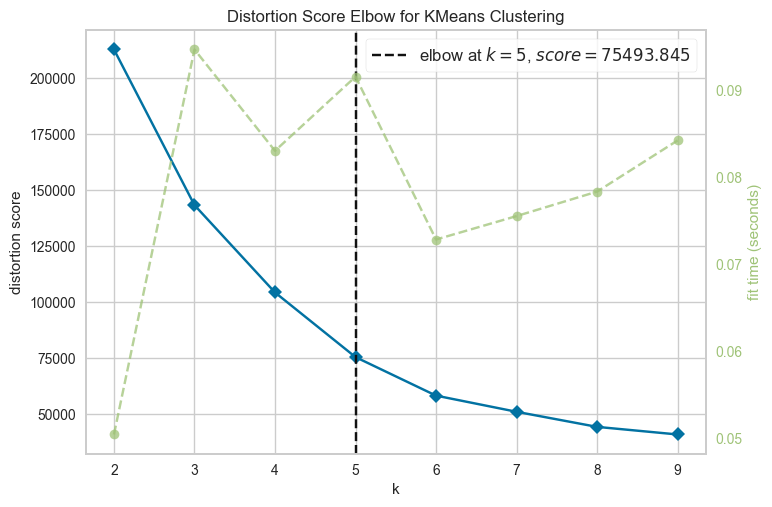

In [15]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(X)
visualizer.show()
plt.show()

Elbow method tells us to select the cluster when there is a significant change in inertia. As we can see from the graph, we can say this may be either 5 or 6. Thanks to plotly, we can zoom. So we'll now proceed to the estimation of the K-means Model with 6 clusters.

In [20]:
#let's proceed the K-means model with the optimal value of K
kmeansmodel = KMeans(n_clusters=5, init='k-means++', n_init = 10 ,max_iter=300, tol=0.0001,  random_state= 111  , algorithm='elkan')
kmeansmodel.fit(X)
df["labels_kmeansmodel"] = kmeansmodel.labels_
centroids3 = kmeansmodel.cluster_centers_
joblib.dump(kmeansmodel, f'../Model/kmeansmodel.pkl')



['../Model/kmeansmodel.pkl']

In [17]:
#the number of customers in each cluster
Kmeans_clust_size = df.groupby("labels_kmeansmodel").size().to_frame()
Kmeans_clust_size.columns = ["K-Means Clusters"]
#rename index to cluster number
Kmeans_clust_size.index.name = 'Cluster'
Kmeans_clust_size

,K-Means Clusters
Cluster,
0,76
1,39
2,37
3,23
4,25


In [394]:
def tracer_kmeans(db, n, name):
    '''
    This function returns trace object for Plotly
    '''
    return go.Scatter3d(
        x = db[db['labels_kmeansmodel']==n]['Age'],
        y = db[db['labels_kmeansmodel']==n]['Spending Score (1-100)'],
        z = db[db['labels_kmeansmodel']==n]['Annual Income (k$)'],
        mode = 'markers',
        name = name,
        marker = dict(
            size = 3
        ),
        opacity=0.8
     )

trace0 = tracer_kmeans(df, 0, 'Cluster Valuable')
trace1 = tracer_kmeans(df, 1, 'Most Valuable')
trace2 = tracer_kmeans(df, 2, 'Targets')
trace3 = tracer_kmeans(df, 3, 'Less Valuable')
trace4 = tracer_kmeans(df, 4, 'Very Valuable')


data_kmeans = [trace2, trace1, trace4, trace0, trace3,]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)
fig_kmeans = go.Figure(data=data_kmeans, layout=layout)
fig_kmeans.update_layout(title_text='Clusters by K-Means', title_x=0.5)

py.offline.iplot(fig_kmeans)

Silhouette score concepts:
- Silhouette score for a set of sample data points is used to measure how dense and well-separated the clusters are.
- Silhouette score takes into consideration the intra-cluster distance between the sample and other data points within the same cluster (a) and inter-cluster distance between the sample and the next nearest cluster (b).
- The silhouette score falls within the range [-1, 1].
- The silhouette score of 1 means that the clusters are very dense and nicely separated. The score of 0 means that clusters are overlapping. The score of less than 0 means that data belonging to clusters may be wrong/incorrect.
- The silhouette plots can be used to select the most optimal value of the K (no. of cluster) in K-means clustering.
- The aspects to look out for in Silhouette plots are cluster scores below the average silhouette score, wide fluctuations in the size of the clusters, and also the thickness of the silhouette plot.

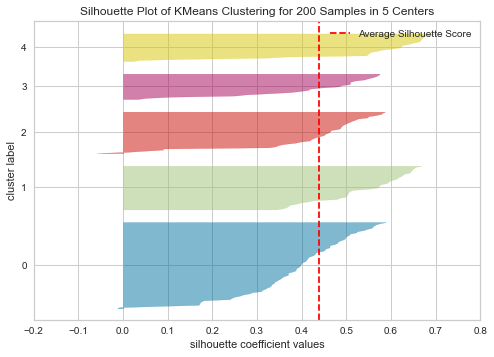

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 200 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [389]:
visualizer_kmeans = SilhouetteVisualizer(kmeansmodel, colors='yellowbrick')
visualizer_kmeans.fit(X)
visualizer_kmeans.show()


In [420]:
# Giving our clusters meaningful names

df['Cluster_kmeans_Label'] = df['labels_kmeansmodel'].apply(lambda x: 'Less Valuable' if x == 3 else
                                               'Targets' if x == 2 else
                                               'Valuable' if x == 0 else
                                               'Very Valuable' if x == 4 else 
                                               'Most valuable' if x == 1 else 'helo')

# New column for radar plots a bit later on 

df['Sex (100=Male)'] = df['Gender'].apply(lambda x: 100 if x == 'Male' else 0)


In [343]:
#transform labels kmeans model to string
df['labels_kmeansmodel'] = df['labels_kmeansmodel'].map(str)
# Order for plotting categorical vars
Cluster_ord_kmeans = ['2','1','4','0','3']
clus_label_order_kmeans = ['Targets','Most valuable','Very Valuable','Valuable','Less Valuable']




clus_ord_kmeans = df['Cluster_kmeans_Label'].value_counts().index

clu_data_kmeans = df['Cluster_kmeans_Label'].value_counts()[clus_label_order_kmeans]
##

data_cg_kmeans = df.groupby('Cluster_kmeans_Label')['Gender'].value_counts().unstack().loc[clus_label_order_kmeans]
data_cg_kmeans['sum'] = data_cg_kmeans.sum(axis=1)

##
data_cg_ratio_kmeans = (data_cg_kmeans.T / data_cg_kmeans['sum']).T[['Male', 'Female']][::-1]

C:\Users\33646\AppData\Local\Temp\ipykernel_14252\2167786872.py:11: UserWarning:

FixedFormatter should only be used together with FixedLocator



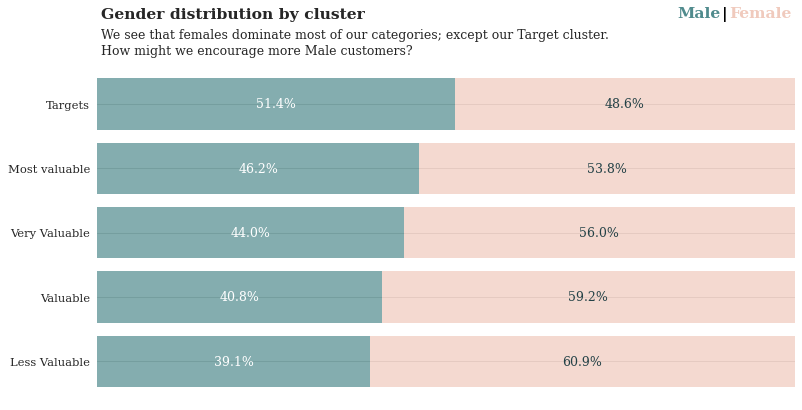

In [395]:
fig_kmeans_gender, ax_kmeans_gender = plt.subplots(1,1,figsize=(12, 6), dpi=75)

ax_kmeans_gender.barh(data_cg_ratio_kmeans.index, data_cg_ratio_kmeans['Male'], 
        color='#508B8D', alpha=0.7, label='Male')
ax_kmeans_gender.barh(data_cg_ratio_kmeans.index, data_cg_ratio_kmeans['Female'], left=data_cg_ratio_kmeans['Male'], 
        color='#F0CABD', alpha=0.7, label='Female')


ax_kmeans_gender.set_xlim(0, 1)
ax_kmeans_gender.set_xticks([])
ax_kmeans_gender.set_yticklabels((data_cg_ratio_kmeans.index), fontfamily='serif', fontsize=11)


# male percentage
for i in data_cg_ratio_kmeans.index:
    ax_kmeans_gender.annotate(f"{data_cg_ratio_kmeans['Male'][i]*100:.3}%", 
                   xy=(data_cg_ratio_kmeans['Male'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='white')

for i in data_cg_ratio_kmeans.index:
    ax_kmeans_gender.annotate(f"{data_cg_ratio_kmeans['Female'][i]*100:.3}%", 
                   xy=(data_cg_ratio_kmeans['Male'][i]+data_cg_ratio_kmeans['Female'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='#244247')
    

fig_kmeans_gender.text(0.129, 0.98, 'Gender distribution by cluster', fontsize=15, fontweight='bold', fontfamily='serif')   
fig_kmeans_gender.text(0.129, 0.9, 
         '''
We see that females dominate most of our categories; except our Target cluster.
How might we encourage more Male customers?''' , fontsize=12,fontfamily='serif')   

for s in ['top', 'left', 'right', 'bottom']:
    ax_kmeans_gender.spines[s].set_visible(False)
    
ax_kmeans_gender.legend().set_visible(False)

fig_kmeans_gender.text(0.77,0.98,"Male", fontweight="bold", fontfamily='serif', fontsize=15, color='#508B8D')
fig_kmeans_gender.text(0.819,0.98,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig_kmeans_gender.text(0.827,0.98,"Female", fontweight="bold", fontfamily='serif', fontsize=15, color='#F0CABD')
fig_kmeans_gender;

C:\Users\33646\AppData\Local\Temp\ipykernel_14252\1168676889.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



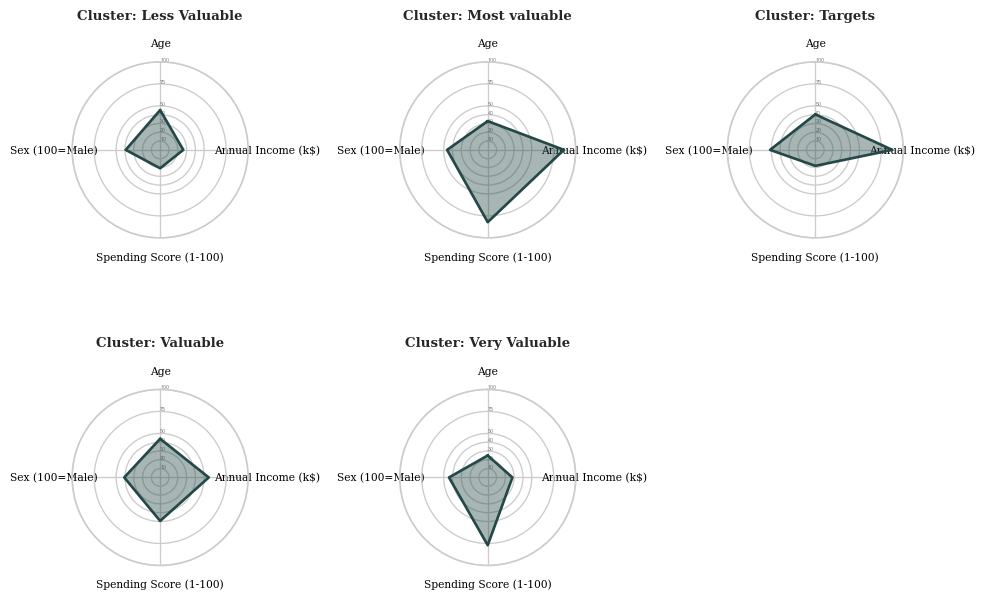

In [386]:
Spider_kmeans = df[['Cluster_kmeans_Label','Age','Annual Income (k$)','Spending Score (1-100)','Sex (100=Male)']]
Spider_kmeans = Spider_kmeans.groupby('Cluster_kmeans_Label')['Cluster_kmeans_Label','Age','Annual Income (k$)','Spending Score (1-100)','Sex (100=Male)'].mean().reset_index()


# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider_kmeans( row, title, color):
 
    # number of variable
    categories=list(Spider_kmeans)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(3,3,row+1, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='black',fontfamily='serif',fontweight='light', size=8)
    #ax.set_xticks([]) # turn labels off if you want - can look quite nice

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([10,20,30,40,50,75,100], ["10","20","30","40","50","75","100"], color="grey", size=4)
    plt.ylim(0,100)

    # Ind1
    values= Spider_kmeans.loc[row].drop('Cluster_kmeans_Label').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=10, fontfamily='serif',fontweight='bold', y=1.2)
    plt.tight_layout()
    
#############################################################################################

my_dpi=96

plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
 
# Create a color palette:
my_palette = plt.cm.get_cmap("crest", len(df.index))
 
# Loop to plot
for row in range(0, len(Spider_kmeans.index)):
    make_spider_kmeans( row=row, title='Cluster: '+ Spider_kmeans['Cluster_kmeans_Label'][row], color='#244747') #change this to my_palette if you want colour to vary by cluster


## Hierarchical Clustering¶

In data mining and statistics, hierarchical clustering (also called hierarchical cluster analysis or HCA) is a method of cluster analysis which seeks to build a hierarchy of clusters. Strategies for hierarchical clustering generally fall into two types:

- Agglomerative: This is a "bottom-up" approach: each observation starts in its own cluster, and pairs of clusters are merged as one moves up the hierarchy.
- Divisive: This is a "top-down" approach: all observations start in one cluster, and splits are performed recursively as one moves down the hierarchy.

In general, the merges and splits are determined in a greedy manner. The results of hierarchical clustering[1] are usually presented in a dendrogram.

In order to decide which clusters should be combined (for agglomerative), or where a cluster should be split (for divisive), a measure of dissimilarity between sets of observations is required. In most methods of hierarchical clustering, this is achieved by use of an appropriate metric (a measure of distance between pairs of observations), and a linkage criterion which specifies the dissimilarity of sets as a function of the pairwise distances of observations in the sets.

We will be looking at Agglomerative Hierarchical Clustering. Agglomerative is the bottom up approach which is more popular than Divisive clustering.

We will also be using Complete Linkage as the Linkage Criteria which is written

$$max ( d(a,b) : a \in A, b \in B )$$

where d is the chosen metric. 

Maximum or complete linkage minimizes the maximum distance between observations of pairs of clusters.

The Agglomerative Clustering class will require two inputs:

- n_clusters: The number of clusters to form as well as the number of centroids to generate.
- linkage: Which linkage criterion to use. The linkage criterion determines which distance to use between sets of observation. The algorithm will merge the pairs of cluster that minimize this criterion.
    - Value will be: 'complete'
    - Note: It is recommended that try everything with 'average' as well

We use in this part : [2],[3]

In [23]:
agglom_model = AgglomerativeClustering(n_clusters=5, linkage='complete').fit(X)
df['Label_agglomerative'] = agglom_model.labels_

joblib.dump(agglom_model, f'../Model/AgglomerativeClustering.pkl')


In [22]:
#the number of customers in each cluster
Agglomérative_clust_size = df.groupby('Label_agglomerative').size().to_frame()
Agglomérative_clust_size.columns = ["Agglomérative Clusters"]
#rename index to cluster number
Agglomérative_clust_size.index.name = 'Cluster'
Agglomérative_clust_size

,Agglomérative Clusters
Cluster,
0,35
1,83
2,39
3,20
4,23


In [399]:

def tracer_Agglomérative(db, n, name):
    '''
    This function returns trace object for Plotly
    '''
    return go.Scatter3d(
        x = db[db['Label_agglomerative']==n]['Age'],
        y = db[db['Label_agglomerative']==n]['Spending Score (1-100)'],
        z = db[db['Label_agglomerative']==n]['Annual Income (k$)'],
        mode = 'markers',
        name = name,
        marker = dict(
            size = 3
        ),
        opacity=0.8
     )

trace0 = tracer_Agglomérative(df, 0, 'Target')
trace1 = tracer_Agglomérative(df, 1, 'Valuable')
trace2 = tracer_Agglomérative(df, 2, 'Most Valuable')
trace3 = tracer_Agglomérative(df, 3, 'Very Valuable')
trace4 = tracer_Agglomérative(df, 4, 'Less valuable')
trace5 = tracer_Agglomérative(df, 5, 'Cluster 5')


data_Agglomérative = [trace0, trace2, trace3, trace1, trace4]


layout = go.Layout(
    title = 'Clusters by Agglomerative Clustering',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig_Agglomérative = go.Figure(data=data_Agglomérative, layout=layout)
fig_Agglomérative.update_layout(title_text='Clusters by Agglomerative Clustering', title_x=0.5)

py.offline.iplot(fig_Agglomérative)

C:\Users\33646\AppData\Local\Temp\ipykernel_14252\137386969.py:2: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



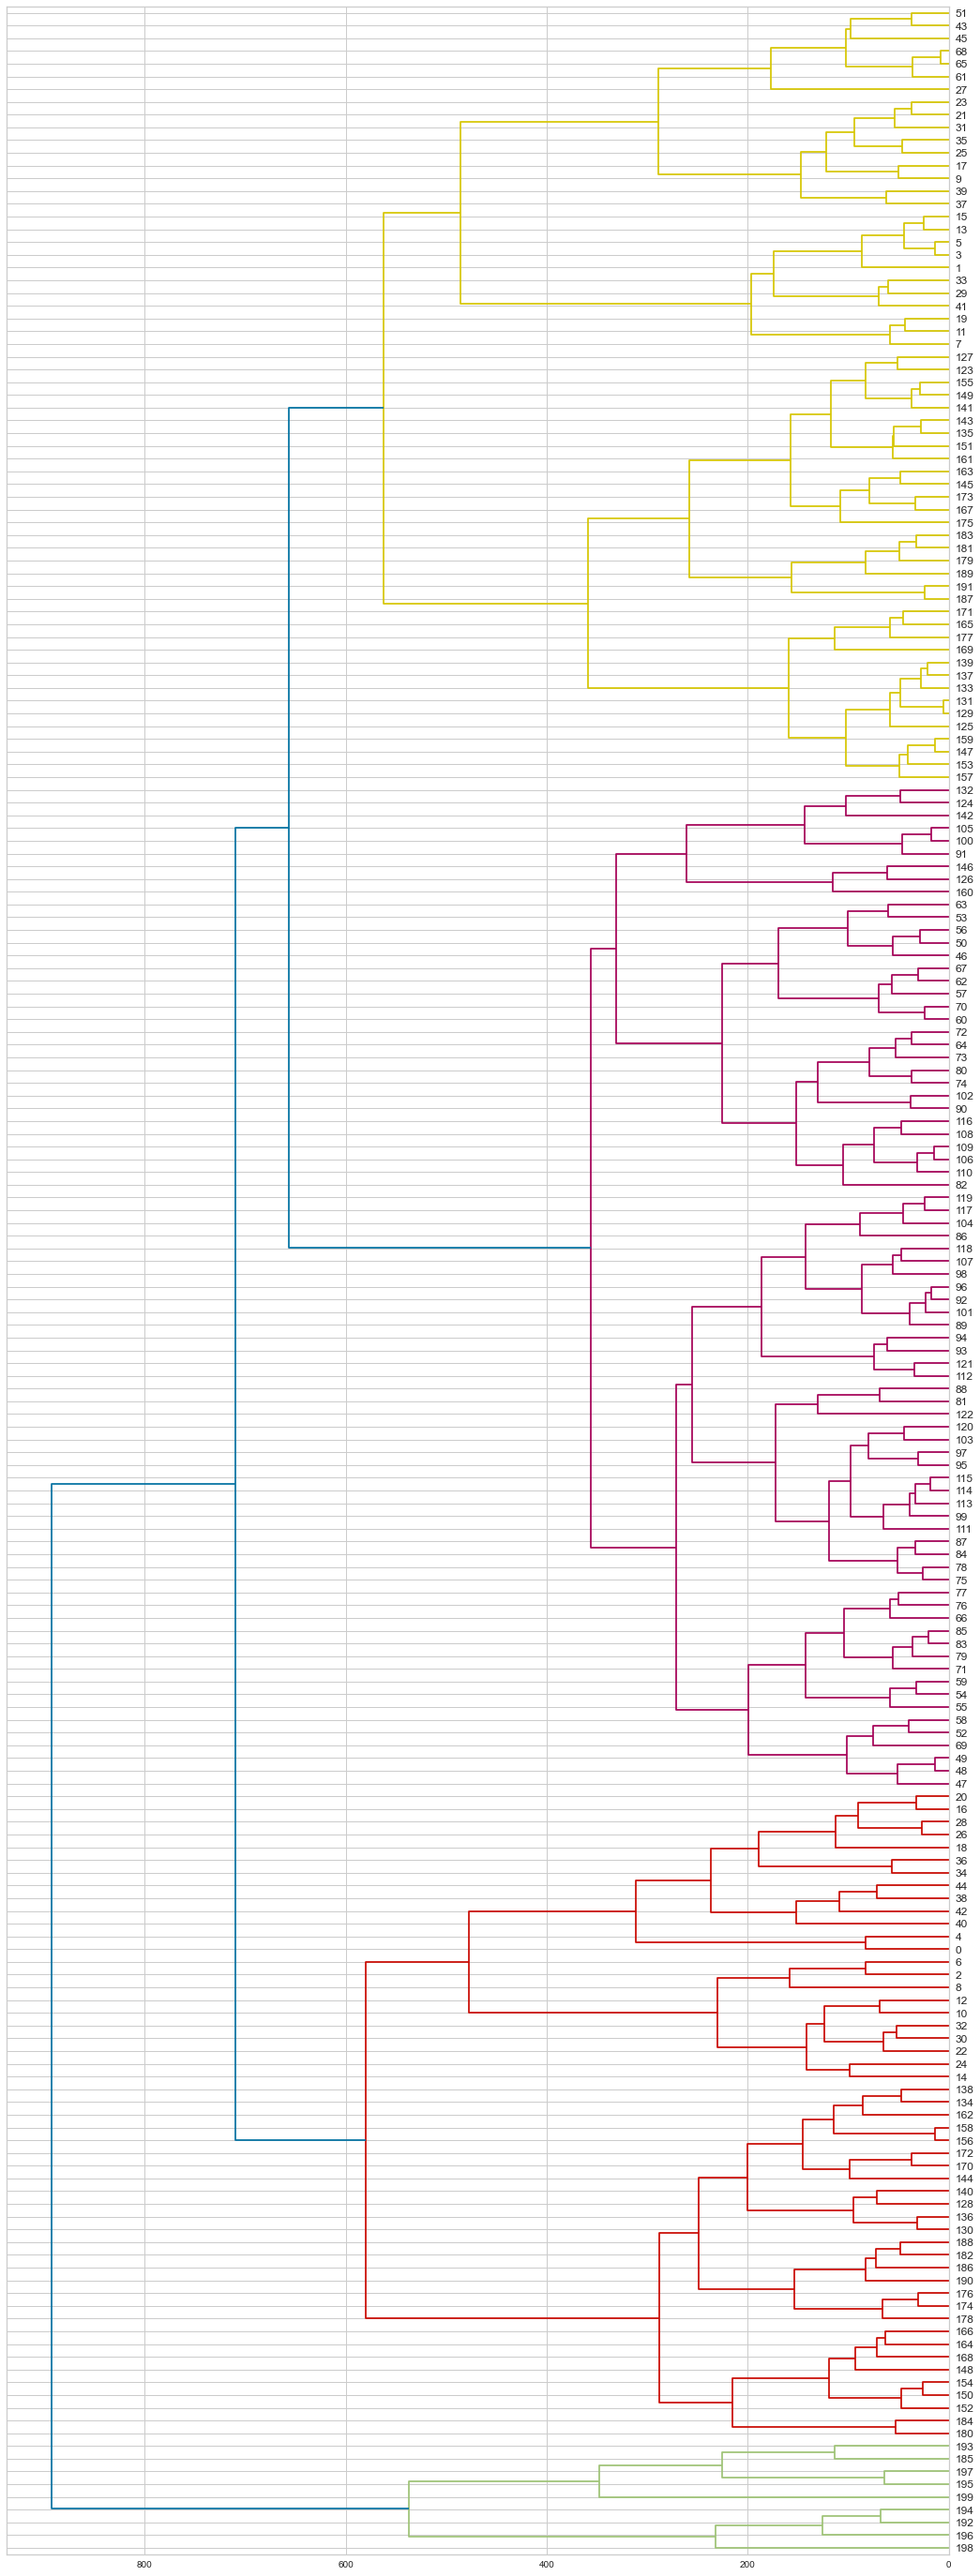

In [302]:
dist = distance_matrix(X, X)
Z = hierarchy.linkage(dist, 'complete',metric="euclidean")

plt.figure(figsize=(18, 50))
dendro = hierarchy.dendrogram(Z, leaf_rotation=0, leaf_font_size=12, orientation='left')

The dendrogram above shows the hierarchical clusters created using complete linkage, which joins pairs of clusters together that have the smallest maximum distance between their observations. The height at which the branches split indicates the distance between the clusters. Clusters that are more similar to each other are joined early on in the tree and become less and less similar as we move up the tree. To identify the number of clusters, we can make a horizontal cut across the dendrogram. For instance, if we were to cut the dendrogram at a height of 90, we would have about six clusters, with the majority of customers in the first cluster, colored purple. Let's look at the results of the hierarchical clustering based on customer's spending and income.

In [24]:
# Giving our clusters meaningful names

df['Cluster_agglomerative_Label'] = df['Label_agglomerative'].apply(lambda x: 'Less Valuable' if x == 4 else
                                               'Targets' if x == 0 else
                                               'Valuable' if x == 1 else
                                               'Very Valuable' if x == 3 else 
                                               'Most valuable' if x == 2 else 'helo')



In [25]:
#transform labels kmeans model to string
df['Label_agglomerative'] = df['Label_agglomerative'].map(str)
# Order for plotting categorical vars
Cluster_ord_agglo = ['0','2','3','1','4']
clus_label_order_agglo = ['Targets','Most valuable','Very Valuable','Valuable','Less Valuable']




clus_ord_agglo = df['Cluster_agglomerative_Label'].value_counts().index

clu_data_agglo = df['Cluster_agglomerative_Label'].value_counts()[clus_label_order_agglo]
##

data_cg_agglo = df.groupby('Cluster_agglomerative_Label')['Gender'].value_counts().unstack().loc[clus_label_order_agglo]
data_cg_agglo['sum'] = data_cg_agglo.sum(axis=1)

##
data_cg_ratio_agglo = (data_cg_agglo.T / data_cg_agglo['sum']).T[['Male', 'Female']][::-1]

C:\Users\33646\AppData\Local\Temp\ipykernel_15172\47329930.py:11: UserWarning:

FixedFormatter should only be used together with FixedLocator



Text(0.827, 0.98, 'Female')

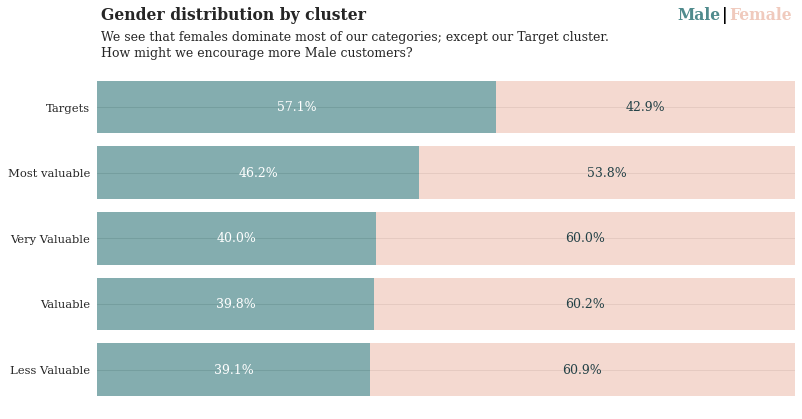

In [26]:
fig_agglo_gender, ax_agglo_gender = plt.subplots(1,1,figsize=(12, 6), dpi=75)

ax_agglo_gender.barh(data_cg_ratio_agglo.index, data_cg_ratio_agglo['Male'], 
        color='#508B8D', alpha=0.7, label='Male')
ax_agglo_gender.barh(data_cg_ratio_agglo.index, data_cg_ratio_agglo['Female'], left=data_cg_ratio_agglo['Male'], 
        color='#F0CABD', alpha=0.7, label='Female')


ax_agglo_gender.set_xlim(0, 1)
ax_agglo_gender.set_xticks([])
ax_agglo_gender.set_yticklabels((data_cg_ratio_agglo.index), fontfamily='serif', fontsize=11)


# male percentage
for i in data_cg_ratio_agglo.index:
    ax_agglo_gender.annotate(f"{data_cg_ratio_agglo['Male'][i]*100:.3}%", 
                   xy=(data_cg_ratio_agglo['Male'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='white')

for i in data_cg_ratio_agglo.index:
    ax_agglo_gender.annotate(f"{data_cg_ratio_agglo['Female'][i]*100:.3}%", 
                   xy=(data_cg_ratio_agglo['Male'][i]+data_cg_ratio_agglo['Female'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='#244247')
    

fig_agglo_gender.text(0.129, 0.98, 'Gender distribution by cluster', fontsize=15, fontweight='bold', fontfamily='serif')   
fig_agglo_gender.text(0.129, 0.9, 
         '''
We see that females dominate most of our categories; except our Target cluster.
How might we encourage more Male customers?''' , fontsize=12,fontfamily='serif')   

for s in ['top', 'left', 'right', 'bottom']:
    ax_agglo_gender.spines[s].set_visible(False)
    
ax_agglo_gender.legend().set_visible(False)

fig_agglo_gender.text(0.77,0.98,"Male", fontweight="bold", fontfamily='serif', fontsize=15, color='#508B8D')
fig_agglo_gender.text(0.819,0.98,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig_agglo_gender.text(0.827,0.98,"Female", fontweight="bold", fontfamily='serif', fontsize=15, color='#F0CABD')

C:\Users\33646\AppData\Local\Temp\ipykernel_14252\2656497488.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



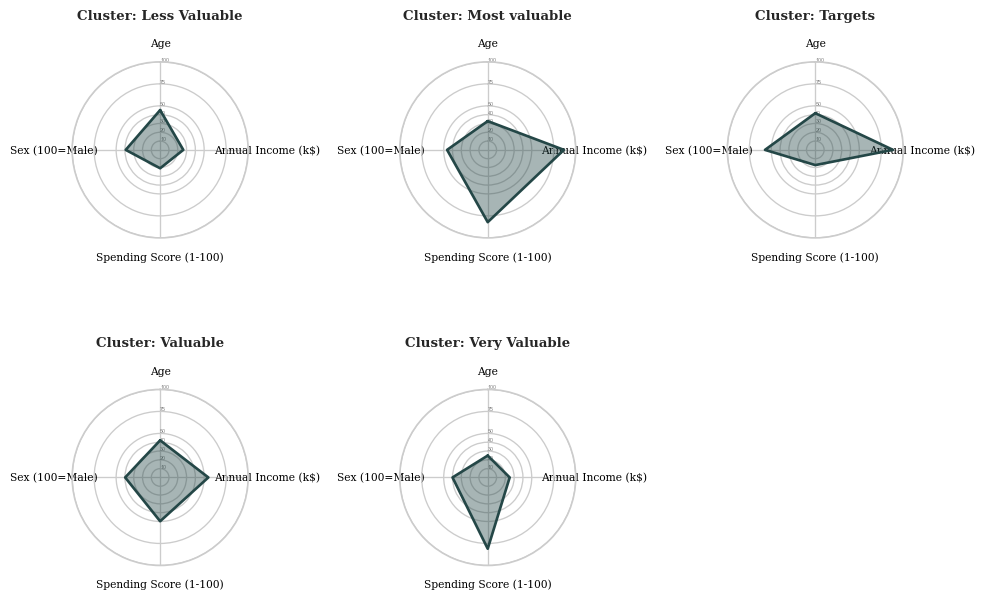

In [385]:
Spider_agglo = df[['Cluster_agglomerative_Label','Age','Annual Income (k$)','Spending Score (1-100)','Sex (100=Male)']]
Spider_agglo = Spider_agglo.groupby('Cluster_agglomerative_Label')['Cluster_agglomerative_Label','Age','Annual Income (k$)','Spending Score (1-100)','Sex (100=Male)'].mean().reset_index()


# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider_agglo( row, title, color):
 
    # number of variable
    categories=list(Spider_agglo)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(3,3,row+1, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='black',fontfamily='serif',fontweight='light', size=8)
    #ax.set_xticks([]) # turn labels off if you want - can look quite nice

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([10,20,30,40,50,75,100], ["10","20","30","40","50","75","100"], color="grey", size=4)
    plt.ylim(0,100)

    # Ind1
    values= Spider_agglo.loc[row].drop('Cluster_agglomerative_Label').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=10, fontfamily='serif',fontweight='bold', y=1.2)
    plt.tight_layout()
    
#############################################################################################

my_dpi=96

plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
 
# Create a color palette:
my_palette = plt.cm.get_cmap("crest", len(df.index))
 
# Loop to plot
for row in range(0, len(Spider_agglo.index)):
    make_spider_agglo( row=row, title='Cluster: '+ Spider_agglo['Cluster_agglomerative_Label'][row], color='#244747') #change this to my_palette if you want colour to vary by cluster


## DBSCAN

DBSCAN stands for Density-Based Spatial Clustering of Applications with Noise and is one of clustering algorithms implemented in scikit-learn library. It was proposed by Martin Ester, Hans-Peter Kriegel, Jörg Sander and Xiaowei Xu in 1996 in their famous article “A Density-Based Algorithm for Discovering Clusters in Large Spatial Database with Noise”.

The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped. The central component to the DBSCAN is the concept of core samples, which are samples that are in areas of high density. A cluster is therefore a set of core samples, each close to each other (measured by some distance measure) and a set of non-core samples that are close to a core sample (but are not themselves core samples). There are two parameters to the algorithm, min_samples and eps, which define formally what we mean when we say dense. Higher min_samples or lower eps indicate higher density necessary to form a cluster.

More formally, we define a core sample as being a sample in the dataset such that there exist min_samples other samples within a distance of eps, which are defined as neighbors of the core sample. This tells us that the core sample is in a dense area of the vector space. A cluster is a set of core samples that can be built by recursively taking a core sample, finding all of its neighbors that are core samples, finding all of their neighbors that are core samples, and so on. A cluster also has a set of non-core samples, which are samples that are neighbors of a core sample in the cluster but are not themselves core samples. Intuitively, these samples are on the fringes of a cluster.

It works based on two parameters: Epsilon and Minimum Points
- Epsilon determine a specified radius that if includes enough number of points within, we call it dense area.
- minimumSamples determine the minimum number of data points we want in a neighborhood to define a cluster.


Advantages of this approach:

- It finds number of clusters itself, based on eps and MinPts parameters
- It is able to differentiate elongated clusters or clusters surrounded by other clusters in contrary to e.g. K-Means where clusters are always convex.
- It is also able to find points not fitting into any cluster – it detects outliers.

The biggest drawback of DBSCAN:

- High computational expense of average O(n log(n)) coming from a need to execute a neighbourhood query for each point.
- Poorly identifies clusters with various densities

This part has been done thanks to [2].



In [27]:
#In DBSCAN there are two major hyperparameters:
# - eps
# - min_samples
#It is difficult arbitrarily to say what values will work the best. 
# Therefore, I will first create a matrix of investigated combinations.



eps_values = np.arange(8,12.75,0.25) # eps values to be investigated
min_samples = np.arange(3,10) # min_samples values to be investigated

DBSCAN_params = list(product(eps_values, min_samples))

Because DBSCAN creates clusters itself based on those two parameters let's check the number of generated clusters.

In [28]:
no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(X)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(X, DBS_clustering.labels_))

A heatplot below shows how many clusters were generated by the DBSCAN algorithm for the respective parameters combinations.

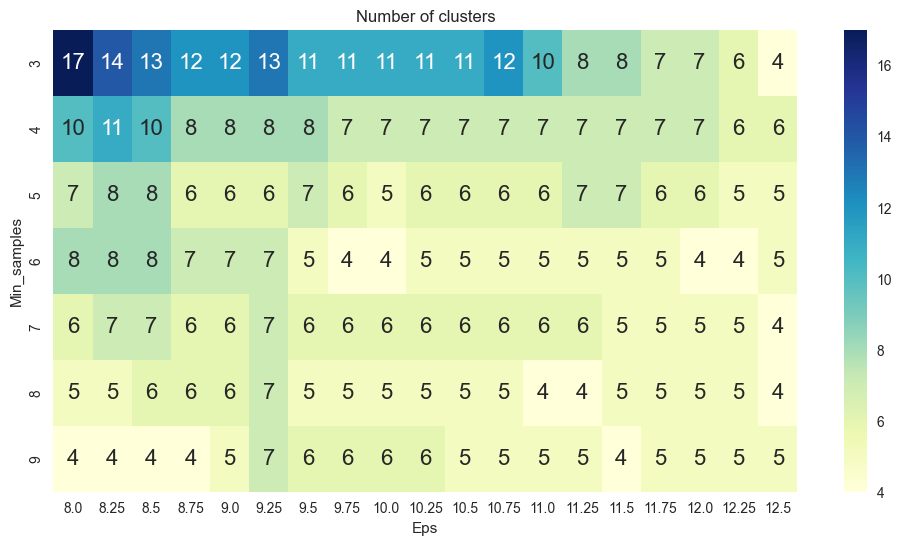

In [29]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

The heatplot above shows, the number of clusters vary from 17 to 4. However, most of the combinations gives 4-7 clusters. To decide which combination to choose I will use a metric - a silhuette score and I will plot it as a heatmap again.

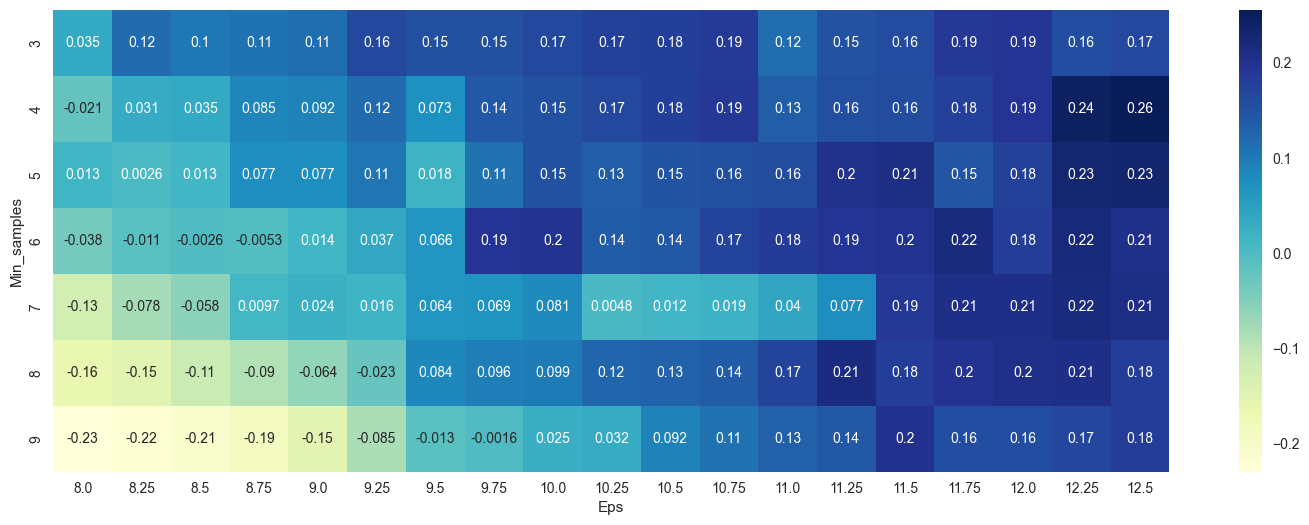

In [30]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig2_DBSCAN, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

Global maximum is 0.26 for eps=12.5 and min_samples=4.

In [31]:
#do DBSCAN clustering with the best parameters
DBS_model = DBSCAN(eps=12.5, min_samples=4).fit(X)

df['label_DBSCAN'] = DBS_model.labels_

joblib.dump(DBS_model, f'../Model/DBSCAN.pkl')



['../Model/DBSCAN.pkl']

In [310]:
#the number of customers in each cluster
DBSCAN_clust_size = df.groupby('label_DBSCAN').size().to_frame()
DBSCAN_clust_size.columns = ["DBSCAN Clusters"]
#rename index to cluster number
DBSCAN_clust_size.index.name = 'Cluster'
DBSCAN_clust_size

,DBSCAN Clusters
Cluster,
-1,18
0,112
1,8
2,34
3,24
4,4


In [405]:

#plot the DBS_clustering results in 3D
#add a legend to the plot

def tracer_DBSCAN(db, n, name):
    '''
    This function returns trace object for Plotly
    '''
    return go.Scatter3d(
        x = db[db['label_DBSCAN']==n]['Age'],
        y = db[db['label_DBSCAN']==n]['Spending Score (1-100)'],
        z = db[db['label_DBSCAN']==n]['Annual Income (k$)'],
        mode = 'markers',
        name = name,
        marker = dict(
            size = 3
        ),
        opacity=0.8
     )

trace0 = tracer_DBSCAN(df, 0, 'Valuable')
trace1 = tracer_DBSCAN(df, 1, 'Least Valuable')
trace2 = tracer_DBSCAN(df, 2, 'Most Valuable')
trace3 = tracer_DBSCAN(df, 3, 'Less Valuable')
trace4 = tracer_DBSCAN(df, 4, 'Targets')
trace_1 = tracer_DBSCAN(df, -1, 'Outliers')


data_DBSCAN = [trace_1,trace1, trace3, trace0, trace2, trace4]

layout = go.Layout(
    title = 'Clusters by DBSCAN Clustering', 
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig_DBSCAN = go.Figure(data=data_DBSCAN, layout=layout)
fig_DBSCAN.update_layout(title_text='Clusters by DBSCAN Clustering', title_x=0.5)
py.offline.iplot(fig_DBSCAN)


In [364]:
# Giving our clusters meaningful names

df['Cluster_DBSCAN_Label'] = df['label_DBSCAN'].apply(lambda x: 'Outliers' if x == -1 else
                                               'Less Valuable' if x == 1 else
                                               'Targets' if x == 4 else
                                               'Valuable' if x == 3 else
                                               'Very Valuable' if x == 0 else 
                                               'Most valuable' if x == 2 else 'helo')


In [362]:
#transform labels kmeans model to string
df['Label_DBSCAN'] = df.label_DBSCAN.map(str)
# Order for plotting categorical vars
Cluster_ord_DBSCAN = ['4','2','0','3','1','-1']
clus_label_order_DBSCAN = ['Targets','Most valuable','Very Valuable','Valuable','Less Valuable', 'Outliers']



clus_ord_DBSCAN = df['Cluster_DBSCAN_Label'].value_counts().index

clu_data_DBSCAN = df['Cluster_DBSCAN_Label'].value_counts()[clus_label_order_agglo]
##

data_cg_DBSCAN = df.groupby('Cluster_DBSCAN_Label')['Gender'].value_counts().unstack().loc[clus_label_order_agglo]
data_cg_DBSCAN['sum'] = data_cg_DBSCAN.sum(axis=1)

##
data_cg_ratio_DBSCAN = (data_cg_DBSCAN.T / data_cg_DBSCAN['sum']).T[['Male', 'Female']][::-1]

C:\Users\33646\AppData\Local\Temp\ipykernel_14252\703143625.py:11: UserWarning:

FixedFormatter should only be used together with FixedLocator



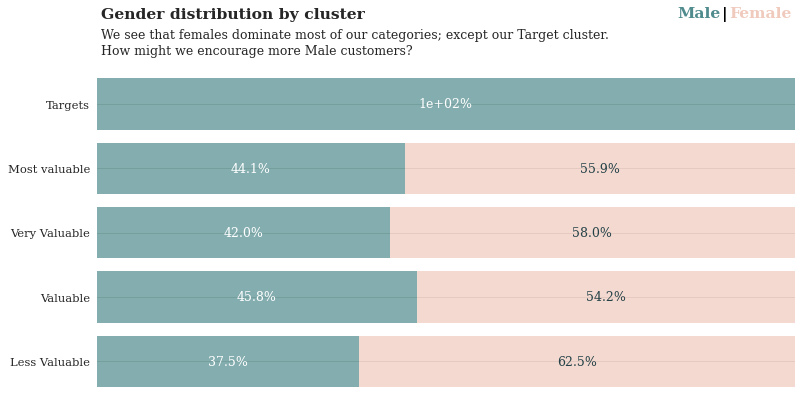

In [363]:
fig_DBSCAN_Gender, ax_DBSCAN_Gender = plt.subplots(1,1,figsize=(12, 6), dpi=75)

ax_DBSCAN_Gender.barh(data_cg_ratio_DBSCAN.index, data_cg_ratio_DBSCAN['Male'], 
        color='#508B8D', alpha=0.7, label='Male')
ax_DBSCAN_Gender.barh(data_cg_ratio_DBSCAN.index, data_cg_ratio_DBSCAN['Female'], left=data_cg_ratio_DBSCAN['Male'], 
        color='#F0CABD', alpha=0.7, label='Female')


ax_DBSCAN_Gender.set_xlim(0, 1)
ax_DBSCAN_Gender.set_xticks([])
ax_DBSCAN_Gender.set_yticklabels((data_cg_ratio_DBSCAN.index), fontfamily='serif', fontsize=11)


# male percentage
for i in data_cg_ratio_DBSCAN.index:
    ax_DBSCAN_Gender.annotate(f"{data_cg_ratio_DBSCAN['Male'][i]*100:.3}%", 
                   xy=(data_cg_ratio_DBSCAN['Male'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='white')

for i in data_cg_ratio_DBSCAN.index:
    ax_DBSCAN_Gender.annotate(f"{data_cg_ratio_DBSCAN['Female'][i]*100:.3}%", 
                   xy=(data_cg_ratio_DBSCAN['Male'][i]+data_cg_ratio_DBSCAN['Female'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='#244247')
    

fig_DBSCAN_Gender.text(0.129, 0.98, 'Gender distribution by cluster', fontsize=15, fontweight='bold', fontfamily='serif')   
fig_DBSCAN_Gender.text(0.129, 0.9, 
         '''
We see that females dominate most of our categories; except our Target cluster.
How might we encourage more Male customers?''' , fontsize=12,fontfamily='serif')   

for s in ['top', 'left', 'right', 'bottom']:
    ax_DBSCAN_Gender.spines[s].set_visible(False)
    
ax_DBSCAN_Gender.legend().set_visible(False)

fig_DBSCAN_Gender.text(0.77,0.98,"Male", fontweight="bold", fontfamily='serif', fontsize=15, color='#508B8D')
fig_DBSCAN_Gender.text(0.819,0.98,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig_DBSCAN_Gender.text(0.827,0.98,"Female", fontweight="bold", fontfamily='serif', fontsize=15, color='#F0CABD')
plt.show()

C:\Users\33646\AppData\Local\Temp\ipykernel_14252\2653078364.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



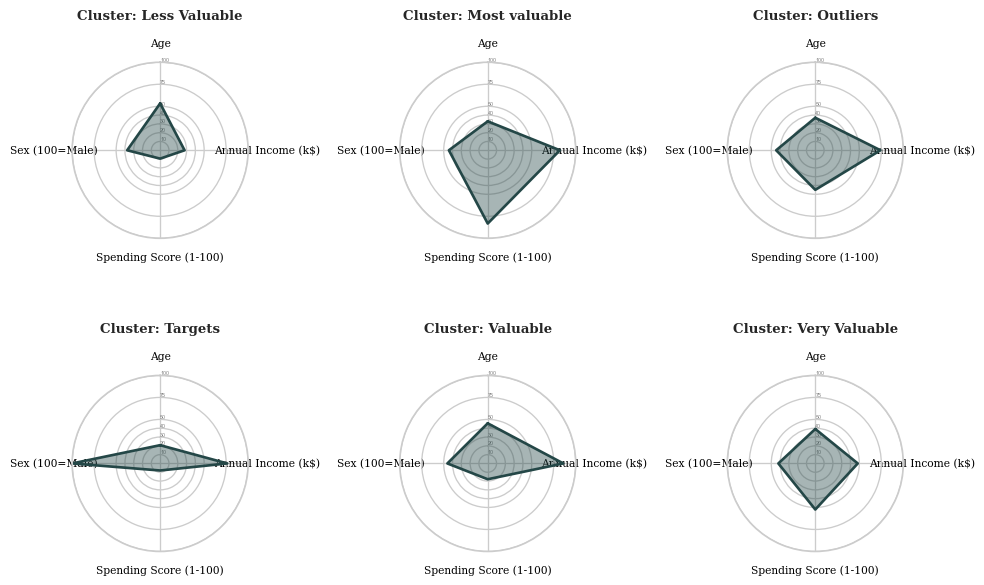

In [384]:
Spider_DBSCAN = df[['Cluster_DBSCAN_Label','Age','Annual Income (k$)','Spending Score (1-100)','Sex (100=Male)']]
Spider_DBSCAN = Spider_DBSCAN.groupby('Cluster_DBSCAN_Label')['Cluster_DBSCAN_Label','Age','Annual Income (k$)','Spending Score (1-100)','Sex (100=Male)'].mean().reset_index()


# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider_DBSCAN( row, title, color):
 
    # number of variable
    categories=list(Spider_DBSCAN)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(3,3,row+1, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='black',fontfamily='serif',fontweight='light', size=8)
    #ax.set_xticks([]) # turn labels off if you want - can look quite nice

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([10,20,30,40,50,75,100], ["10","20","30","40","50","75","100"], color="grey", size=4)
    plt.ylim(0,100)

    # Ind1
    values= Spider_DBSCAN.loc[row].drop('Cluster_DBSCAN_Label').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=10, fontfamily='serif',fontweight='bold', y=1.2)
    plt.tight_layout()
    
#############################################################################################

my_dpi=96

plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
 
# Create a color palette:
my_palette = plt.cm.get_cmap("crest", len(df.index))
 
# Loop to plot
for row in range(0, len(Spider_DBSCAN.index)):
    make_spider_DBSCAN( row=row, title='Cluster: '+ Spider_DBSCAN['Cluster_DBSCAN_Label'][row], color='#244747') #change this to my_palette if you want colour to vary by cluster


## Affinity Propagation

Affinity Propagation is a clustering algorithm proposed for the first time by Brendan Frey and Delbert Dueck in 2007 ("Clustering by Passing Messages Between Data Points").

AffinityPropagation creates clusters by sending messages between pairs of samples until convergence. A dataset is then described using a small number of exemplars, which are identified as those most representative of other samples. The messages sent between pairs represent the suitability for one sample to be the exemplar of the other, which is updated in response to the values from other pairs. This updating happens iteratively until convergence, at which point the final exemplars are chosen, and hence the final clustering is given.

Affinity Propagation can be interesting as it chooses the number of clusters based on the data provided. For this purpose, the two important parameters are :
- the preference, which controls how many exemplars are used
- the damping factor which damps the responsibility and availability messages to avoid numerical oscillations when updating these messages.

The main drawback of Affinity Propagation is its complexity. The algorithm has a time complexity of the order $O(N^2T)$, where $N$ is the number of samples and $T$ is the number of iterations until convergence. Further, the memory complexity is of the order $O(N^2)$ if a dense similarity matrix is used, but reducible if a sparse similarity matrix is used. This makes Affinity Propagation most appropriate for small to medium sized datasets.


Algorithm description: The messages sent between points belong to one of two categories. The first is the responsibility $r(i,k)$, which is the accumulated evidence that sample $k$ should be the exemplar for sample $i$. The second is the availability $a(i,k)$ which is the accumulated evidence that sample $i$ should choose sample $k$ to be its exemplar, and considers the values for all other samples that $k$ should be an exemplar. In this way, exemplars are chosen by samples if they are (1) similar enough to many samples and (2) chosen by many samples to be representative of themselves.

More formally, the responsibility of a sample $k$ to be the exemplar of sample $i$ is given by:
$$r(i,k) <- s(i,k) - max[a(i,k') + s(i,k') \forall k' \neq k]$$

$$a(i,k) <- min[0,r(k,k) + \sum_{i' s.t. i' \notin {i,k}} r(i',k) ]$$

To begin with, all values for  and  are set to zero, and the calculation of each iterates until convergence. As discussed above, in order to avoid numerical oscillations when updating the messages, the damping factor  is introduced to iteration process

$$r_{t+1}(i,k) = \lambda * r_{t}(i,k) + (1- \lambda) r_{t+1}(i,k) $$
$$a_{t+1}(i,k) = \lambda * a_{t}(i,k) + (1- \lambda) a_{t+1}(i,k) $$

where $t$ indicates the iteration times.

In [369]:
##Clustering with Affinity Propagation.
##This technique is very important as it segments the data without the need to specify the number of clusters.
##Clustering with Affinity Propagation.
##This technique is very important as it segments the data without the need to specify the number of clusters.
no_of_clusters = []
preferences = range(-20000,-5000,100) # arbitraty chosen range
af_sil_score = [] # silouette scores

for p in preferences:
    AF = AffinityPropagation(preference=p, max_iter=200).fit(X)
    no_of_clusters.append((len(np.unique(AF.labels_))))
    if len(np.unique(AF.labels_)) > 1:
        af_sil_score.append(silhouette_score(X, AF.labels_))
    af_sil_score.append(af_sil)
    
af_results = pd.DataFrame([preferences, no_of_clusters, af_sil_score], index=['preference','clusters', 'sil_score']).T
#drop na of af_results of preference
af_results = af_results.dropna()
af_results.sort_values(by='sil_score', ascending=False).head() # display only 5 best scores

c:\Users\33646\anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:250: ConvergenceWarning:

Affinity propagation did not converge, this model will not have any cluster centers.



,preference,clusters,sil_score
54,-14600.0,6.0,0.451491
102,-9800.0,7.0,0.451491
75,-12500.0,6.0,0.451440
114,-8600.0,6.0,0.451440
66,-13400.0,6.0,0.451440


In [32]:
AF_model = AffinityPropagation(preference=-14600).fit(X)

df['label_Affinity_Propagation'] = AF_model.labels_

joblib.dump(AF_model, f'../Model/AffinityPropagation.pkl')



['../Model/AffinityPropagation.pkl']

In [415]:
#the number of customers in each cluster
Affinity_Propagation_clust_size = df.groupby('label_Affinity_Propagation').size().to_frame()
Affinity_Propagation_clust_size.columns = ["Affinity Propagation Clusters"]
#rename index to cluster number
Affinity_Propagation_clust_size.index.name = 'Cluster'
Affinity_Propagation_clust_size

,Affinity Propagation Clusters
Cluster,
0,23
1,22
2,44
3,38
4,34
5,39


In [421]:

#plot the DBS_clustering results in 3D
#add a legend to the plot

def tracer_Affinity_Propagation(db, n, name):
    '''
    This function returns trace object for Plotly
    '''
    return go.Scatter3d(
        x = db[db['label_Affinity_Propagation']==n]['Age'],
        y = db[db['label_Affinity_Propagation']==n]['Spending Score (1-100)'],
        z = db[db['label_Affinity_Propagation']==n]['Annual Income (k$)'],
        mode = 'markers',
        name = name,
        marker = dict(
            size = 3
        ),
        opacity=0.8
     )

trace0 = tracer_Affinity_Propagation(df, 0, 'Very Valuable')
trace1 = tracer_Affinity_Propagation(df, 1, 'Less valuable')
trace2 = tracer_Affinity_Propagation(df, 2, 'Valuable 2')
trace3 = tracer_Affinity_Propagation(df, 3, 'Valuable')
trace4 = tracer_Affinity_Propagation(df, 4, 'Target')
trace5 = tracer_Affinity_Propagation(df, 5, 'Most valuable')


data_Affinity_Propagation = [trace4, trace5, trace0, trace2, trace3,trace1]


layout = go.Layout(
    title = 'Clusters by Affinity Propagation Clustering',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig_Affinity_Propagation = go.Figure(data=data_Affinity_Propagation, layout=layout)
fig_Affinity_Propagation.update_layout(title_text='Clusters by Affinity Propagation Clustering', title_x=0.5)
py.offline.iplot(fig_Affinity_Propagation)

In [422]:
# Giving our clusters meaningful names

df['Cluster_Affinity_Propagation_Label'] = df['label_Affinity_Propagation'].apply(lambda x: 'Less Valuable' if x == 1 else
                                               'Targets' if x == 4 else
                                               'Valuable' if x == 3 else
                                               'Valuable 2' if x == 2 else
                                               'Very Valuable' if x == 0 else 
                                               'Most valuable' if x == 5 else 'helo')

In [423]:
#transform labels kmeans model to string
df['label_Affinity_Propagation'] = df.label_Affinity_Propagation.map(str)
# Order for plotting categorical vars
Cluster_ord_AF = ['4','5','0','2','3','1']
clus_label_order_AF = ['Targets','Most valuable','Very Valuable',"Valuable 2",'Valuable','Less Valuable']



clus_ord_AF = df['Cluster_Affinity_Propagation_Label'].value_counts().index

clu_data_AF = df['Cluster_Affinity_Propagation_Label'].value_counts()[clus_label_order_agglo]
##

data_cg_AF = df.groupby('Cluster_Affinity_Propagation_Label')['Gender'].value_counts().unstack().loc[clus_label_order_agglo]
data_cg_AF['sum'] = data_cg_AF.sum(axis=1)

##
data_cg_ratio_AF = (data_cg_AF.T / data_cg_AF['sum']).T[['Male', 'Female']][::-1]

C:\Users\33646\AppData\Local\Temp\ipykernel_14252\2059127471.py:11: UserWarning:

FixedFormatter should only be used together with FixedLocator



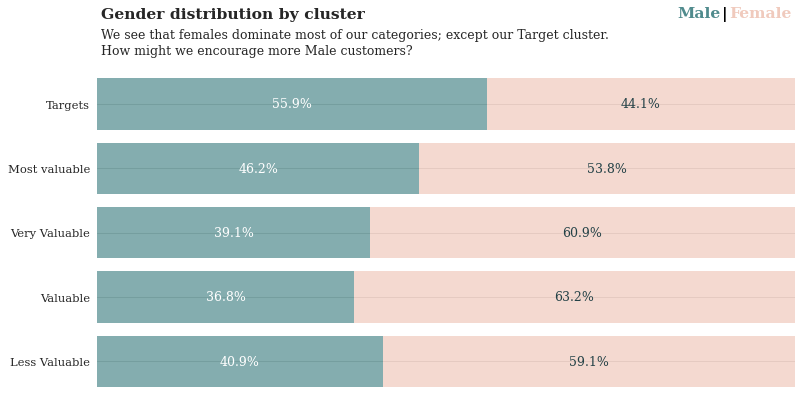

In [424]:
fig_AF_Gender, ax_AF_Gender = plt.subplots(1,1,figsize=(12, 6), dpi=75)

ax_AF_Gender.barh(data_cg_ratio_AF.index, data_cg_ratio_AF['Male'], 
        color='#508B8D', alpha=0.7, label='Male')
ax_AF_Gender.barh(data_cg_ratio_AF.index, data_cg_ratio_AF['Female'], left=data_cg_ratio_AF['Male'], 
        color='#F0CABD', alpha=0.7, label='Female')


ax_AF_Gender.set_xlim(0, 1)
ax_AF_Gender.set_xticks([])
ax_AF_Gender.set_yticklabels((data_cg_ratio_AF.index), fontfamily='serif', fontsize=11)


# male percentage
for i in data_cg_ratio_AF.index:
    ax_AF_Gender.annotate(f"{data_cg_ratio_AF['Male'][i]*100:.3}%", 
                   xy=(data_cg_ratio_AF['Male'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='white')

for i in data_cg_ratio_AF.index:
    ax_AF_Gender.annotate(f"{data_cg_ratio_AF['Female'][i]*100:.3}%", 
                   xy=(data_cg_ratio_AF['Male'][i]+data_cg_ratio_AF['Female'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='#244247')
    

fig_AF_Gender.text(0.129, 0.98, 'Gender distribution by cluster', fontsize=15, fontweight='bold', fontfamily='serif')   
fig_AF_Gender.text(0.129, 0.9, 
         '''
We see that females dominate most of our categories; except our Target cluster.
How might we encourage more Male customers?''' , fontsize=12,fontfamily='serif')   

for s in ['top', 'left', 'right', 'bottom']:
    ax_AF_Gender.spines[s].set_visible(False)
    
ax_AF_Gender.legend().set_visible(False)

fig_AF_Gender.text(0.77,0.98,"Male", fontweight="bold", fontfamily='serif', fontsize=15, color='#508B8D')
fig_AF_Gender.text(0.819,0.98,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig_AF_Gender.text(0.827,0.98,"Female", fontweight="bold", fontfamily='serif', fontsize=15, color='#F0CABD')
plt.show()

C:\Users\33646\AppData\Local\Temp\ipykernel_14252\598710365.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



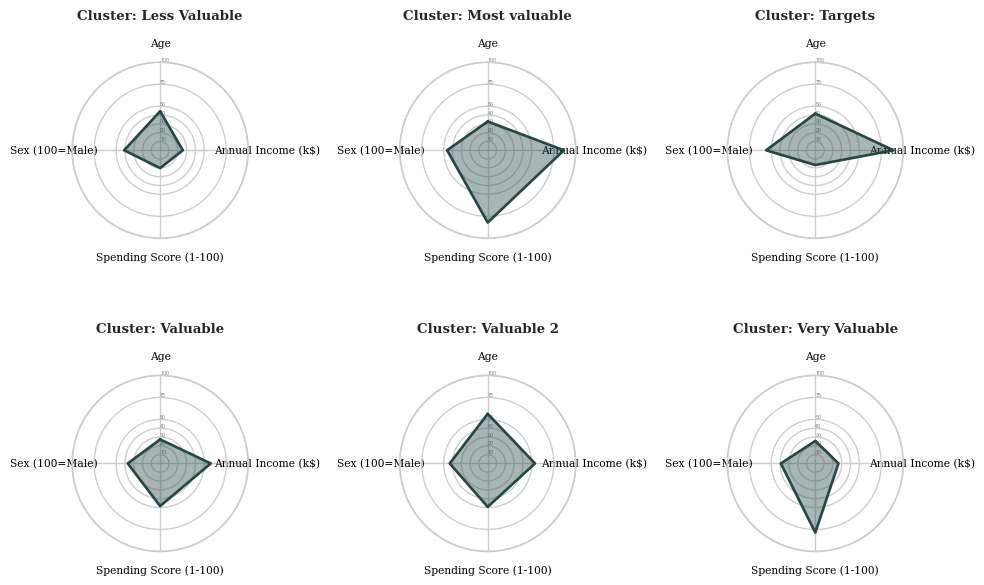

In [425]:
Spider_AF = df[['Cluster_Affinity_Propagation_Label','Age','Annual Income (k$)','Spending Score (1-100)','Sex (100=Male)']]
Spider_AF = Spider_AF.groupby('Cluster_Affinity_Propagation_Label')['Cluster_Affinity_Propagation_Label','Age','Annual Income (k$)','Spending Score (1-100)','Sex (100=Male)'].mean().reset_index()


# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider_AF( row, title, color):
 
    # number of variable
    categories=list(Spider_AF)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(3,3,row+1, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='black',fontfamily='serif',fontweight='light', size=8)
    #ax.set_xticks([]) # turn labels off if you want - can look quite nice

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([10,20,30,40,50,75,100], ["10","20","30","40","50","75","100"], color="grey", size=4)
    plt.ylim(0,100)

    # Ind1
    values= Spider_AF.loc[row].drop('Cluster_Affinity_Propagation_Label').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=10, fontfamily='serif',fontweight='bold', y=1.2)
    plt.tight_layout()
    
#############################################################################################

my_dpi=96

plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
 
# Create a color palette:
my_palette = plt.cm.get_cmap("crest", len(df.index))
 
# Loop to plot
for row in range(0, len(Spider_AF.index)):
    make_spider_AF( row=row, title='Cluster: '+ Spider_AF['Cluster_Affinity_Propagation_Label'][row], color='#244747') #change this to my_palette if you want colour to vary by cluster


# Conclusion

Let's display the clusters of each model in a dataframe

In [427]:
clusters = pd.concat([Kmeans_clust_size,Agglomérative_clust_size, DBSCAN_clust_size, Affinity_Propagation_clust_size],axis=1, sort=False)
clusters.sort_index(inplace=True)
clusters

,K-Means Clusters,Agglomérative Clusters,DBSCAN Clusters,Affinity Propagation Clusters
Cluster,,,,
-1,NaN,NaN,18.0,NaN
0,76.0,35.0,112.0,23.0
1,39.0,83.0,8.0,22.0
2,37.0,39.0,34.0,44.0
3,23.0,20.0,24.0,38.0
4,25.0,23.0,4.0,34.0
5,NaN,NaN,NaN,39.0


In this analysis, four clustering models were developed to explore different types of customers at a supermarket: K-Means Clustering, Hierarchical Clustering, DBSCAN and Affinity Propagation. Each model identified distinct customer segments that the company could target depending on their needs.

The K-Means and hierarchical clustering created 5 clusters with huge cluster. The DBSCAN created 5 cluster and emphasized outliers. However, some clusters are very small. The affinity propagation created 6 clusters with no small cluster.

The K-Means, Hierarchical, and Affinity Propagation created a cluster which is very interesting. It is a cluster of people who has huge income and small spending score. The mall should do an advertisement by targeting these customers. However, the DBSCAN did not succeed to emphasize a cluster of this type.

If we delve deeper into these cluster, We can see that these target cluster are the only one who has more men than women, so we could also emphasize our advertises on men, directly inside the Mall.






## Bibliographie :
[1] https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python

[2] https://scikit-learn.org/stable/modules/clustering.html

[3] https://en.wikipedia.org/wiki/Hierarchical_clustering

[4] https://www.kaggle.com/code/kellibelcher/customer-segmentation-and-clustering-analysis - Some of the visualization

[5] https://www.kaggle.com/code/joshuaswords/data-visualization-clustering-mall-data - Some of the visualization

[6] https://www.kaggle.com/code/datark1/customers-clustering-k-means-dbscan-and-ap - The DBSCAN model